In [98]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

df = pd.read_csv("dataset/hcc_dataset.csv")
df.head()


,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,Male,No,Yes,No,No,No,No,Yes,No,Yes,...,150,7.1,0.7,1,3.5,0.5,?,?,?,Lives
1,Female,?,No,No,No,No,Yes,Yes,?,?,...,?,?,?,1,1.8,?,?,?,?,Lives
2,Male,No,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109,7,2.1,5,13,0.1,28,6,16,Lives
3,Male,Yes,Yes,No,No,No,No,Yes,No,Yes,...,174,8.1,1.11,2,15.7,0.2,?,?,?,Dies
4,Male,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,...,109,6.9,1.8,1,9,?,59,15,22,Lives


As células com valores faltantes estão demarcadas com '?', enquanto que nas colunas "Ascites" e "Encephalopathy", há elementos com valores "none", com sentido de "no". Por isso, o tratamentos das colunas vazias é realizada em duas etapas.

In [99]:
df.fillna('No', inplace=True)

In [100]:
df = df.map(lambda x: np.NaN if x == '?' else x)


Analisando os histogramas abaixo é possível notar que "Age", "INR", "Hemoglobin", "MCV", "Albumin" e "Iron" parece seguir uma distribuição normal, o que espero que possa nos ajudar a completar os valores faltantes 

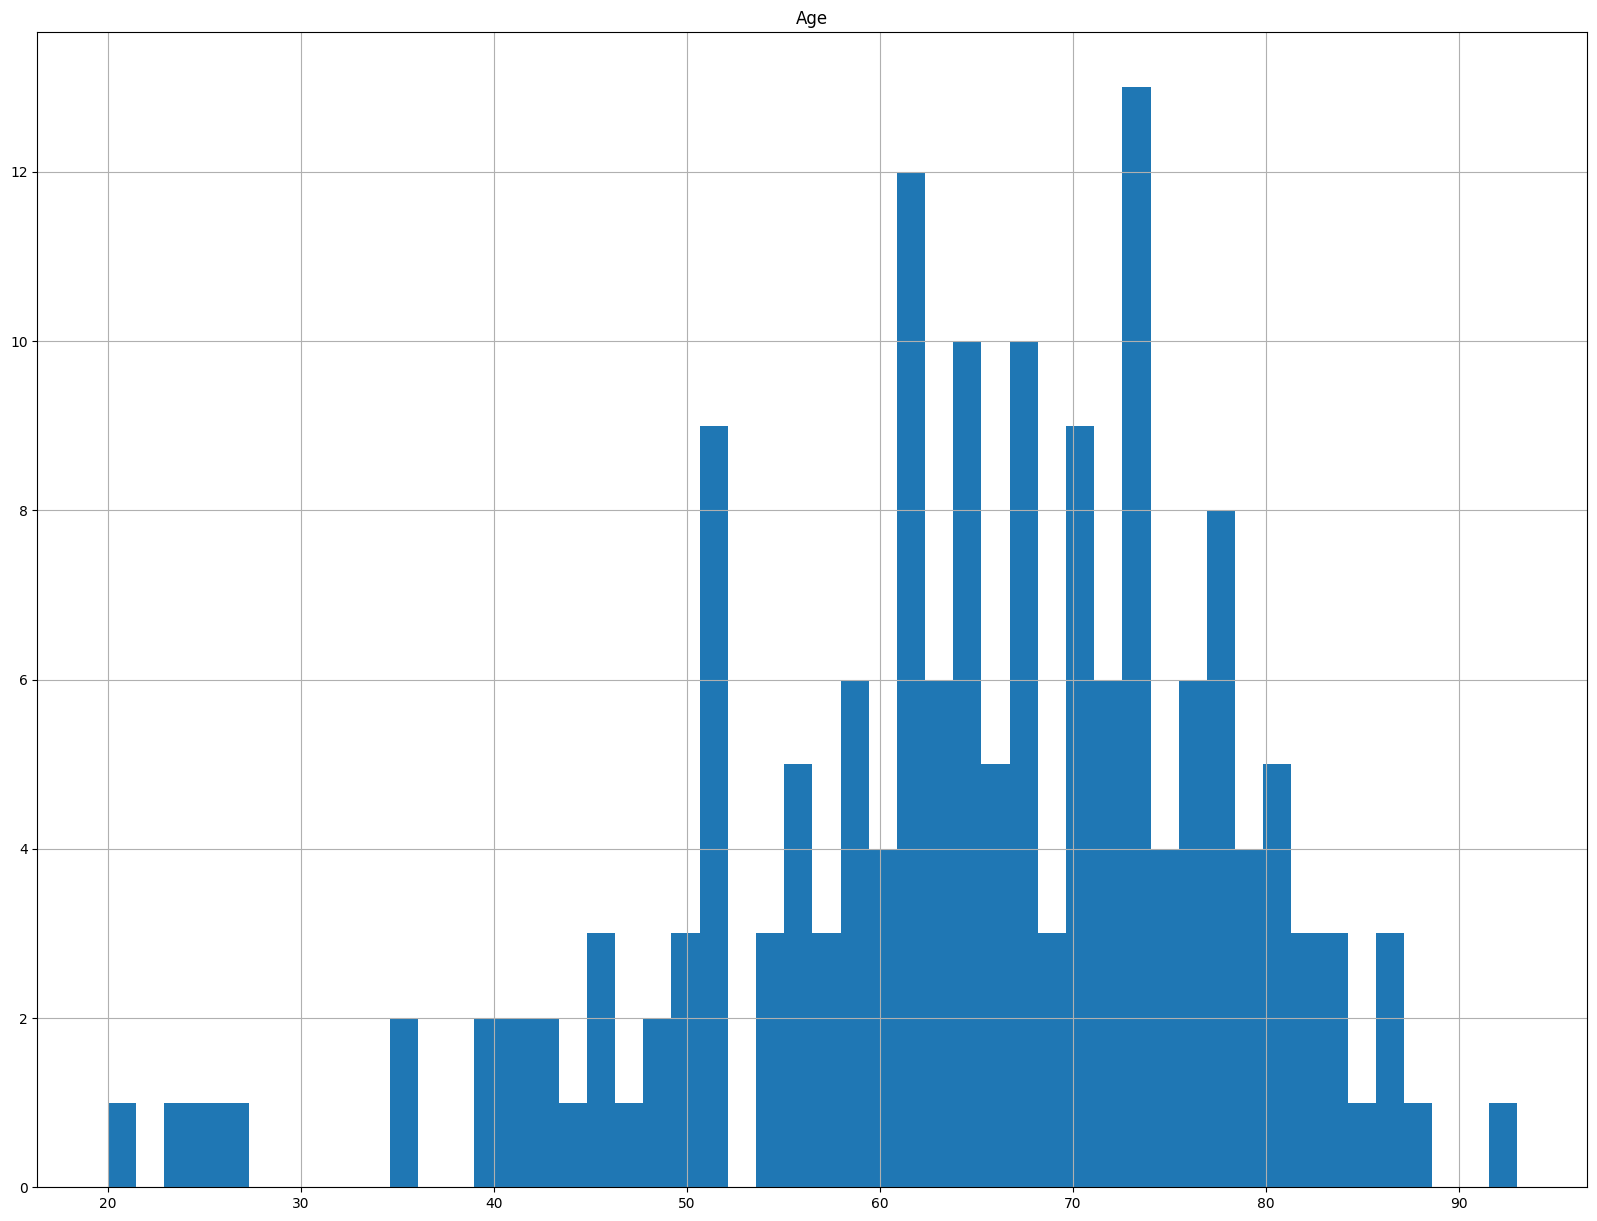

In [101]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [102]:
print("Number of people analised:", df.shape[0])
print("Number of features:", df.shape[1]-1) #A ultima coluna é a classificação
print("\n")
df.info()


Number of people analised: 165
Number of features: 49


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          165 non-null    object
 1   Symptoms        147 non-null    object
 2   Alcohol         165 non-null    object
 3   HBsAg           148 non-null    object
 4   HBeAg           126 non-null    object
 5   HBcAb           141 non-null    object
 6   HCVAb           156 non-null    object
 7   Cirrhosis       165 non-null    object
 8   Endemic         126 non-null    object
 9   Smoking         124 non-null    object
 10  Diabetes        162 non-null    object
 11  Obesity         155 non-null    object
 12  Hemochro        142 non-null    object
 13  AHT             162 non-null    object
 14  CRI             163 non-null    object
 15  HIV             151 non-null    object
 16  NASH            143 non-null    object
 17

Importante saber quais features possuem valores contínuos e discretos.
Pois podemos utilizar ideias estatisticas para preencher os valores contínuos, enquanto que para os valores discretos utilizamos a moda.

In [103]:
true_false, other_types = 2, 5 

# <lista para armazenar as features contínuas e discretas
true_false_features = []
other_types_features = []
continuous_features = []

# Verifica a cardinalidade dos valores únicos em cada coluna
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values <= true_false:
        true_false_features.append(column)
    elif unique_values > true_false and unique_values <= other_types:
        other_types_features.append(column)

    else:
        continuous_features.append(column)

print("Features com valores contínuos:", continuous_features)
print("Features com valores true or false:", true_false_features)
print("Features com outros valores categoricos:", other_types_features)

Features com valores contínuos: ['Age', 'Grams_day', 'Packs_year', 'INR', 'AFP', 'Hemoglobin', 'MCV', 'Leucocytes', 'Platelets', ' Albumin', 'Total_Bil', 'ALT', 'AST', 'GGT', 'ALP', 'TP', 'Creatinine', 'Nodules', 'Major_Dim', 'Dir_Bil', 'Iron', 'Sat', 'Ferritin']
Features com valores true or false: ['Gender', 'Symptoms', 'Alcohol', 'HBsAg', 'HBeAg', 'HBcAb', 'HCVAb', 'Cirrhosis', 'Endemic', 'Smoking', 'Diabetes', 'Obesity', 'Hemochro', 'AHT', 'CRI', 'HIV', 'NASH', 'Varices', 'Spleno', 'PHT', 'PVT', 'Metastasis', 'Hallmark', 'Class']
Features com outros valores categoricos: ['PS', 'Encephalopathy', 'Ascites']


In [104]:
print("Valores nulos por atributo:")
df.isnull().sum()


Valores nulos por atributo:


Gender             0
Symptoms          18
Alcohol            0
HBsAg             17
HBeAg             39
HBcAb             24
HCVAb              9
Cirrhosis          0
Endemic           39
Smoking           41
Diabetes           3
Obesity           10
Hemochro          23
AHT                3
CRI                2
HIV               14
NASH              22
Varices           52
Spleno            15
PHT               11
PVT                3
Metastasis         4
Hallmark           2
Age                0
Grams_day         48
Packs_year        53
PS                 0
Encephalopathy     1
Ascites            2
INR                4
AFP                8
Hemoglobin         3
MCV                3
Leucocytes         3
Platelets          3
 Albumin           6
Total_Bil          5
ALT                4
AST                3
GGT                3
ALP                3
TP                11
Creatinine         7
Nodules            2
Major_Dim         20
Dir_Bil           44
Iron              79
Sat          

In [105]:
df.describe()

,Age
count,165.000000
mean,64.690909
std,13.319534
min,20.000000
25%,57.000000
50%,66.000000
75%,74.000000
max,93.000000


Vou dividir os dados pelo género do paciente.

In [106]:
male = df[df['Gender'] == 'Male']
#male.hist(bins=50, figsize=(20,15))
num_male=male.shape[0]
print("Número de homens infetados:",num_male)

Número de homens infetados: 133


In [107]:
female = df[df['Gender'] == 'Female']
#female.hist(bins=50, figsize=(20,15))
num_female=female.shape[0]
print("Número de mulheres infetadas:",num_female)

Número de mulheres infetadas: 32


Há muitos mais homens infetados que mulheres mas não existem evidências óbvias que os diversos parâmetros diferem significativamente de mulher para homem.

In [108]:
jovens = df[(df['Age'] >= 20) & (df['Age'] < 40)]
num_jovens=jovens.shape[0]
print("Número de jovens infetados:",num_jovens)
adultos = df[(df['Age'] >= 40) & (df['Age'] < 60)]
num_adultos=adultos.shape[0]
print("Número de adultos infetados:",num_adultos)
idosos = df[(df['Age'] >= 60) & (df['Age'] < 100)]
num_idosos=idosos.shape[0]
print("Número de idosos infetados:",num_idosos)

Número de jovens infetados: 6
Número de adultos infetados: 42
Número de idosos infetados: 117


Análise de outliers tendo em conta a sua definição estatística:

In [109]:
numeric_columns = df.columns[0:]  # Exclude the first 22 non-numeric columns

for column in numeric_columns:
    class_distribution = df[column].value_counts()
    print("\nClass Distribution:",class_distribution)
    if df[column].nunique() <= 1:
        print("Constant or Near-Constant Feature")
        
    if df[column].dtype == 'float64':  # Check if the column contains float values
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        counter=0
        # Count outliers directly using boolean indexing
        outliers = (df[column] < lower_limit) | (df[column] > upper_limit)
        num_outliers = outliers.sum()

        #print(f"Column: {column}")
        #print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        #print(f"Lower Limit: {lower_limit:.2f}, Upper Limit: {upper_limit:.2f}")
        print(f"Number of outliers: {num_outliers}\n")



Class Distribution: Gender
Male      133
Female     32
Name: count, dtype: int64

Class Distribution: Symptoms
Yes    94
No     53
Name: count, dtype: int64

Class Distribution: Alcohol
Yes    122
No      43
Name: count, dtype: int64

Class Distribution: HBsAg
No     132
Yes     16
Name: count, dtype: int64

Class Distribution: HBeAg
No     125
Yes      1
Name: count, dtype: int64

Class Distribution: HBcAb
No     103
Yes     38
Name: count, dtype: int64

Class Distribution: HCVAb
No     122
Yes     34
Name: count, dtype: int64

Class Distribution: Cirrhosis
Yes    149
No      16
Name: count, dtype: int64

Class Distribution: Endemic
No     116
Yes     10
Name: count, dtype: int64

Class Distribution: Smoking
Yes    63
No     61
Name: count, dtype: int64

Class Distribution: Diabetes
No     106
Yes     56
Name: count, dtype: int64

Class Distribution: Obesity
No     135
Yes     20
Name: count, dtype: int64

Class Distribution: Hemochro
No     135
Yes      7
Name: count, dtype: int64



Transformar Gender e Class em valores númericos.

In [110]:
true_false_features.remove('Gender')
true_false_features.remove('Class')


df = pd.get_dummies(df, columns=['Gender'], dtype=float)
df = pd.get_dummies(df, columns=['Class'], dtype=float, drop_first=True).rename(columns={"Class_Lives": "Class"})
pd.set_option('display.max_columns', None)
df

,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,Diabetes,Obesity,Hemochro,AHT,CRI,HIV,NASH,Varices,Spleno,PHT,PVT,Metastasis,Hallmark,Age,Grams_day,Packs_year,PS,Encephalopathy,Ascites,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Gender_Female,Gender_Male,Class
0,No,Yes,No,No,No,No,Yes,No,Yes,Yes,NaN,Yes,No,No,No,No,Yes,No,No,No,No,Yes,67,137,15,Active,No,No,1.53,95,13.7,106.6,4.9,99,3.4,2.1,34,41,183,150,7.1,0.7,1,3.5,0.5,NaN,NaN,NaN,0.0,1.0,1.0
1,NaN,No,No,No,No,Yes,Yes,NaN,NaN,Yes,No,No,Yes,No,No,No,Yes,No,No,No,No,Yes,62,0,NaN,Active,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.8,NaN,NaN,NaN,NaN,1.0,0.0,1.0
2,No,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,78,50,50,Ambulatory,No,Mild,0.96,5.8,8.9,79.8,8.4,472,3.3,0.4,58,68,202,109,7,2.1,5,13,0.1,28,6,16,0.0,1.0,1.0
3,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,Yes,Yes,77,40,30,Active,No,No,0.95,2440,13.4,97.1,9,279,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.2,NaN,NaN,NaN,0.0,1.0,0.0
4,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes,Yes,No,No,No,No,No,No,No,Yes,76,100,30,Active,No,No,0.94,49,14.3,95.1,6.4,199,4.1,0.7,147,306,173,109,6.9,1.8,1,9,NaN,59,15,22,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,No,Yes,NaN,NaN,NaN,Yes,Yes,No,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No,No,40,NaN,NaN,Active,No,No,0.84,NaN,15.4,109.2,9.3,184000,4.6,0.5,35,40,449,109,7.6,0.7,5,3,NaN,NaN,NaN,NaN,1.0,0.0,1.0
161,Yes,No,NaN,NaN,NaN,NaN,Yes,No,No,No,No,No,Yes,No,NaN,No,Yes,Yes,Yes,No,No,Yes,68,0,0,Ambulatory,No,No,1.33,4887,12.1,88.9,2.5,141,3,3.6,50,91,147,280,6.7,0.7,1,2.2,2.3,NaN,NaN,NaN,1.0,0.0,0.0
162,No,Yes,No,No,No,No,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,NaN,NaN,NaN,NaN,No,No,Yes,65,NaN,48,Active,No,No,1.13,75,13.3,90,8,385000,4.3,0.6,53,52,164,181,7.5,1.46,5,18.6,NaN,NaN,NaN,NaN,0.0,1.0,1.0
163,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,Yes,No,NaN,NaN,NaN,Yes,Yes,Yes,44,NaN,NaN,Ambulatory,No,No,2.14,94964,15.6,117.3,5200,118000,4.8,1.1,50,60,320,170,8.4,0.74,5,18,NaN,NaN,NaN,NaN,0.0,1.0,0.0


In [111]:


df = pd.get_dummies(df, columns=true_false_features, drop_first=True, dtype=float)
df = pd.get_dummies(df, columns=other_types_features, dtype=float)

target = 'Class'
cols = [col for col in df.columns if col != target]
cols.append(target)
df = df.reindex(columns=cols)

df


,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Gender_Female,Gender_Male,Symptoms_Yes,Alcohol_Yes,HBsAg_Yes,HBeAg_Yes,HBcAb_Yes,HCVAb_Yes,Cirrhosis_Yes,Endemic_Yes,Smoking_Yes,Diabetes_Yes,Obesity_Yes,Hemochro_Yes,AHT_Yes,CRI_Yes,HIV_Yes,NASH_Yes,Varices_Yes,Spleno_Yes,PHT_Yes,PVT_Yes,Metastasis_Yes,Hallmark_Yes,PS_Active,PS_Ambulatory,PS_Disabled,PS_Restricted,PS_Selfcare,Encephalopathy_Grade I/II,Encephalopathy_Grade III/IV,Encephalopathy_No,Ascites_Mild,Ascites_Moderate/Severe,Ascites_No,Class
0,67,137,15,1.53,95,13.7,106.6,4.9,99,3.4,2.1,34,41,183,150,7.1,0.7,1,3.5,0.5,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.8,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,78,50,50,0.96,5.8,8.9,79.8,8.4,472,3.3,0.4,58,68,202,109,7,2.1,5,13,0.1,28,6,16,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,77,40,30,0.95,2440,13.4,97.1,9,279,3.7,0.4,16,64,94,174,8.1,1.11,2,15.7,0.2,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,76,100,30,0.94,49,14.3,95.1,6.4,199,4.1,0.7,147,306,173,109,6.9,1.8,1,9,NaN,59,15,22,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,40,NaN,NaN,0.84,NaN,15.4,109.2,9.3,184000,4.6,0.5,35,40,449,109,7.6,0.7,5,3,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
161,68,0,0,1.33,4887,12.1,88.9,2.5,141,3,3.6,50,91,147,280,6.7,0.7,1,2.2,2.3,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
162,65,NaN,48,1.13,75,13.3,90,8,385000,4.3,0.6,53,52,164,181,7.5,1.46,5,18.6,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
163,44,NaN,NaN,2.14,94964,15.6,117.3,5200,118000,4.8,1.1,50,60,320,170,8.4,0.74,5,18,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [112]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df)

scaled_data = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

df = scaled_df
df

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Gender_Female,Gender_Male,Symptoms_Yes,Alcohol_Yes,HBsAg_Yes,HBeAg_Yes,HBcAb_Yes,HCVAb_Yes,Cirrhosis_Yes,Endemic_Yes,Smoking_Yes,Diabetes_Yes,Obesity_Yes,Hemochro_Yes,AHT_Yes,CRI_Yes,HIV_Yes,NASH_Yes,Varices_Yes,Spleno_Yes,PHT_Yes,PVT_Yes,Metastasis_Yes,Hallmark_Yes,PS_Active,PS_Ambulatory,PS_Disabled,PS_Restricted,PS_Selfcare,Encephalopathy_Grade I/II,Encephalopathy_Grade III/IV,Encephalopathy_No,Ascites_Mild,Ascites_Moderate/Severe,Ascites_No,Class
0,0.643836,0.274,0.029412,0.173367,0.000052,0.635036,0.740519,0.000208,0.000212,0.500000,0.044776,0.056235,0.044776,0.103093,0.151954,0.032620,0.067568,0.2,0.097561,0.013699,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.575342,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.014634,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.794521,0.100,0.098039,0.030151,0.000003,0.284672,0.205589,0.000477,0.001025,0.466667,0.002488,0.114914,0.095149,0.115335,0.110062,0.031600,0.256757,1.0,0.560976,0.000000,0.125000,0.047619,0.007175,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.780822,0.080,0.058824,0.027638,0.001347,0.613139,0.550898,0.000523,0.000604,0.600000,0.002488,0.012225,0.087687,0.045747,0.176475,0.042813,0.122973,0.4,0.692683,0.003425,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.767123,0.200,0.058824,0.025126,0.000026,0.678832,0.510978,0.000323,0.000430,0.733333,0.009950,0.332518,0.539179,0.096649,0.110062,0.030581,0.216216,0.2,0.365854,NaN,0.263393,0.119048,0.009865,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.273973,NaN,NaN,0.000000,NaN,0.759124,0.792415,0.000546,0.400869,0.900000,0.004975,0.058680,0.042910,0.274485,0.110062,0.037717,0.067568,1.0,0.073171,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
161,0.657534,0.000,0.000000,0.123116,0.002699,0.518248,0.387226,0.000023,0.000303,0.366667,0.082090,0.095355,0.138060,0.079897,0.284780,0.028542,0.067568,0.2,0.034146,0.075342,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
162,0.616438,NaN,0.094118,0.072864,0.000041,0.605839,0.409182,0.000446,0.838779,0.800000,0.007463,0.102689,0.065299,0.090851,0.183628,0.036697,0.170270,1.0,0.834146,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
163,0.328767,NaN,NaN,0.326633,0.052456,0.773723,0.954092,0.399898,0.257078,0.966667,0.019900,0.095355,0.080224,0.191366,0.172388,0.045872,0.072973,1.0,0.804878,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Eliminar linhas com mais de determinados valores faltantes, pois como serão preenchidos com base em moda e mediana, podem ser muito enviesados.

In [113]:
df = df[df.isnull().sum(axis=1) < 12]
df

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Gender_Female,Gender_Male,Symptoms_Yes,Alcohol_Yes,HBsAg_Yes,HBeAg_Yes,HBcAb_Yes,HCVAb_Yes,Cirrhosis_Yes,Endemic_Yes,Smoking_Yes,Diabetes_Yes,Obesity_Yes,Hemochro_Yes,AHT_Yes,CRI_Yes,HIV_Yes,NASH_Yes,Varices_Yes,Spleno_Yes,PHT_Yes,PVT_Yes,Metastasis_Yes,Hallmark_Yes,PS_Active,PS_Ambulatory,PS_Disabled,PS_Restricted,PS_Selfcare,Encephalopathy_Grade I/II,Encephalopathy_Grade III/IV,Encephalopathy_No,Ascites_Mild,Ascites_Moderate/Severe,Ascites_No,Class
0,0.643836,0.274,0.029412,0.173367,0.000052,0.635036,0.740519,0.000208,0.000212,0.500000,0.044776,0.056235,0.044776,0.103093,0.151954,0.032620,0.067568,0.2,0.097561,0.013699,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.794521,0.100,0.098039,0.030151,0.000003,0.284672,0.205589,0.000477,0.001025,0.466667,0.002488,0.114914,0.095149,0.115335,0.110062,0.031600,0.256757,1.0,0.560976,0.000000,0.125000,0.047619,0.007175,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.780822,0.080,0.058824,0.027638,0.001347,0.613139,0.550898,0.000523,0.000604,0.600000,0.002488,0.012225,0.087687,0.045747,0.176475,0.042813,0.122973,0.4,0.692683,0.003425,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.767123,0.200,0.058824,0.025126,0.000026,0.678832,0.510978,0.000323,0.000430,0.733333,0.009950,0.332518,0.539179,0.096649,0.110062,0.030581,0.216216,0.2,0.365854,NaN,0.263393,0.119048,0.009865,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5,0.753425,NaN,NaN,0.185930,0.000060,0.613139,0.439122,0.000246,0.000181,0.500000,0.079602,0.195599,0.195896,0.141108,0.403302,0.017329,0.094595,0.2,0.414634,0.044521,0.236607,0.174603,0.049776,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.273973,NaN,NaN,0.000000,NaN,0.759124,0.792415,0.000546,0.400869,0.900000,0.004975,0.058680,0.042910,0.274485,0.110062,0.037717,0.067568,1.0,0.073171,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
161,0.657534,0.000,0.000000,0.123116,0.002699,0.518248,0.387226,0.000023,0.000303,0.366667,0.082090,0.095355,0.138060,0.079897,0.284780,0.028542,0.067568,0.2,0.034146,0.075342,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
162,0.616438,NaN,0.094118,0.072864,0.000041,0.605839,0.409182,0.000446,0.838779,0.800000,0.007463,0.102689,0.065299,0.090851,0.183628,0.036697,0.170270,1.0,0.834146,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
163,0.328767,NaN,NaN,0.326633,0.052456,0.773723,0.954092,0.399898,0.257078,0.966667,0.019900,0.095355,0.080224,0.191366,0.172388,0.045872,0.072973,1.0,0.804878,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [114]:
from sklearn.impute import KNNImputer

# Inicializando o KNNImputer
imputer = KNNImputer(n_neighbors=6, weights="distance")  # Você pode ajustar o número de vizinhos conforme necessário

# Aplicando o imputer ao DataFrame
df_imputed = imputer.fit_transform(df)

# Convertendo o resultado de volta para um DataFrame do Pandas
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df = df_imputed
df

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,Total_Bil,ALT,AST,GGT,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Gender_Female,Gender_Male,Symptoms_Yes,Alcohol_Yes,HBsAg_Yes,HBeAg_Yes,HBcAb_Yes,HCVAb_Yes,Cirrhosis_Yes,Endemic_Yes,Smoking_Yes,Diabetes_Yes,Obesity_Yes,Hemochro_Yes,AHT_Yes,CRI_Yes,HIV_Yes,NASH_Yes,Varices_Yes,Spleno_Yes,PHT_Yes,PVT_Yes,Metastasis_Yes,Hallmark_Yes,PS_Active,PS_Ambulatory,PS_Disabled,PS_Restricted,PS_Selfcare,Encephalopathy_Grade I/II,Encephalopathy_Grade III/IV,Encephalopathy_No,Ascites_Mild,Ascites_Moderate/Severe,Ascites_No,Class
0,0.643836,0.274000,0.029412,0.173367,0.000052,0.635036,0.740519,0.000208,0.000212,0.500000,0.044776,0.056235,0.044776,0.103093,0.151954,0.032620,0.067568,0.2,0.097561,0.013699,0.394964,0.206624,0.159647,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.794521,0.100000,0.098039,0.030151,0.000003,0.284672,0.205589,0.000477,0.001025,0.466667,0.002488,0.114914,0.095149,0.115335,0.110062,0.031600,0.256757,1.0,0.560976,0.000000,0.125000,0.047619,0.007175,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.780822,0.080000,0.058824,0.027638,0.001347,0.613139,0.550898,0.000523,0.000604,0.600000,0.002488,0.012225,0.087687,0.045747,0.176475,0.042813,0.122973,0.4,0.692683,0.003425,0.254601,0.185011,0.171499,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.767123,0.200000,0.058824,0.025126,0.000026,0.678832,0.510978,0.000323,0.000430,0.733333,0.009950,0.332518,0.539179,0.096649,0.110062,0.030581,0.216216,0.2,0.365854,0.012407,0.263393,0.119048,0.009865,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.753425,0.168609,0.037605,0.185930,0.000060,0.613139,0.439122,0.000246,0.000181,0.500000,0.079602,0.195599,0.195896,0.141108,0.403302,0.017329,0.094595,0.2,0.414634,0.044521,0.236607,0.174603,0.049776,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.273973,0.098470,0.043415,0.000000,0.000071,0.759124,0.792415,0.000546,0.400869,0.900000,0.004975,0.058680,0.042910,0.274485,0.110062,0.037717,0.067568,1.0,0.073171,0.009125,0.455812,0.280313,0.114191,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
158,0.657534,0.000000,0.000000,0.123116,0.002699,0.518248,0.387226,0.000023,0.000303,0.366667,0.082090,0.095355,0.138060,0.079897,0.284780,0.028542,0.067568,0.2,0.034146,0.075342,0.305612,0.271398,0.106803,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
159,0.616438,0.188031,0.094118,0.072864,0.000041,0.605839,0.409182,0.000446,0.838779,0.800000,0.007463,0.102689,0.065299,0.090851,0.183628,0.036697,0.170270,1.0,0.834146,0.013343,0.268359,0.173149,0.107327,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
160,0.328767,0.158660,0.204329,0.326633,0.052456,0.773723,0.954092,0.399898,0.257078,0.966667,0.019900,0.095355,0.080224,0.191366,0.172388,0.045872,0.072973,1.0,0.804878,0.036916,0.476612,0.297621,0.201384,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Abaixo é criada a matriz de correlação, e após avaliada são eliminadas as features com menos de 1.1% de correlação absoluta, o que após algumas verificações é notado significamente a melhoria do recall que é a nossa métrica mais signficativa para o caso determinado, que é evitar falsos negativos. TESTE UTILIZANDO CORRELAÇÃO DE SPEARMAN.

In [115]:
# matriz de correlação entre as features e o target
correlation_matrix = df.corr("spearman")['Class']
print(correlation_matrix)
# Extraia a correlação entre as features e o target (última coluna da matriz de correlação)
target_correlation = correlation_matrix.iloc[:-1]

# Filtra as colunas que têm correlação abaixo de determinado valor
discard_columns = target_correlation[abs(target_correlation) < 0.2].index
columns_to_keep = target_correlation[abs(target_correlation) >= 0.2].index
print(discard_columns)
# Mantém apenas as colunas selecionadas no DataFrame original
df = df[columns_to_keep].join(df['Class'])
df

Age                           -0.150883
Grams_day                      0.028626
Packs_year                     0.031680
INR                           -0.166953
AFP                           -0.376646
Hemoglobin                     0.314035
MCV                            0.060790
Leucocytes                    -0.116307
Platelets                     -0.122256
 Albumin                       0.293428
Total_Bil                     -0.164882
ALT                           -0.045497
AST                           -0.248587
GGT                           -0.184803
ALP                           -0.388299
TP                             0.112582
Creatinine                    -0.132459
Nodules                       -0.086730
Major_Dim                     -0.172394
Dir_Bil                       -0.254289
Iron                           0.356066
Sat                            0.140804
Ferritin                      -0.349561
Gender_Female                  0.009175
Gender_Male                   -0.009175


,AFP,Hemoglobin,Albumin,AST,ALP,Dir_Bil,Iron,Ferritin,Symptoms_Yes,PVT_Yes,Metastasis_Yes,PS_Active,PS_Disabled,PS_Selfcare,Ascites_Moderate/Severe,Ascites_No,Class
0,0.000052,0.635036,0.500000,0.044776,0.151954,0.013699,0.394964,0.159647,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.000003,0.284672,0.466667,0.095149,0.110062,0.000000,0.125000,0.007175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.001347,0.613139,0.600000,0.087687,0.176475,0.003425,0.254601,0.171499,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000026,0.678832,0.733333,0.539179,0.110062,0.012407,0.263393,0.009865,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.000060,0.613139,0.500000,0.195896,0.403302,0.044521,0.236607,0.049776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.000071,0.759124,0.900000,0.042910,0.110062,0.009125,0.455812,0.114191,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
158,0.002699,0.518248,0.366667,0.138060,0.284780,0.075342,0.305612,0.106803,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
159,0.000041,0.605839,0.800000,0.065299,0.183628,0.013343,0.268359,0.107327,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
160,0.052456,0.773723,0.966667,0.080224,0.172388,0.036916,0.476612,0.201384,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Salvar o df final.

In [116]:
df.to_csv('dataset/final_hcc_dataset.csv', index= False)

In [117]:
X = df.drop('Class', axis=1)
y = df['Class']

Abaixo temos a implementação de diferentes modelos, e a métrica que nos é mais importante é o recall 0.0, pois se refere aos falsos negativos, números que queremos evitar a todo o custo.

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Suponha que X seja o DataFrame das features e y seja a Series do target

# Divida os dados em conjuntos de treinamento e teste, mantendo as proporções dos valores de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# Inicialize os modelos
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
logistic_regression = LogisticRegression()
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=10) 

# Treine os modelos
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)


# Faça previsões
dt_predictions = decision_tree.predict(X_test)
rf_predictions = random_forest.predict(X_test)
lr_predictions = logistic_regression.predict(X_test)
svm_predictions = svm.predict(X_test)
knn_predictions = knn.predict(X_test)


# Avalie os modelos
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))


# Matriz de confusão
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_predictions))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))


# Relatório de classificação
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))
print("KNN Classification Report:\n", classification_report(y_test, knn_predictions))



Decision Tree Accuracy: 0.5454545454545454
Random Forest Accuracy: 0.696969696969697
Logistic Regression Accuracy: 0.6666666666666666
SVM Accuracy: 0.7575757575757576
KNN Accuracy: 0.7575757575757576
Decision Tree Confusion Matrix:
 [[ 6  7]
 [ 8 12]]
Random Forest Confusion Matrix:
 [[ 7  6]
 [ 6 14]]
Logistic Regression Confusion Matrix:
 [[ 6  7]
 [ 4 16]]
SVM Confusion Matrix:
 [[10  3]
 [ 5 15]]
KNN Confusion Matrix:
 [[ 9  4]
 [ 4 16]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.46      0.44        13
         1.0       0.63      0.60      0.62        20

    accuracy                           0.55        33
   macro avg       0.53      0.53      0.53        33
weighted avg       0.55      0.55      0.55        33

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.54      0.54        13
         1.0       0.70      0.70      0.7

Guardar os modelos como variáveis para usar na app.

In [119]:
import pickle

with open('variables/models.pkl', 'wb') as f:
    pickle.dump({'decision_tree': decision_tree, 'random_forest': random_forest, 'logistic_regression': logistic_regression, 'svm': svm, 'knn': knn}, f)


Model: Decision Tree
Mean Accuracy: 0.7010
Standard Deviation: 0.0668
Min Accuracy: 0.5312
Max Accuracy: 0.8485
Mean ROC AUC: 0.6825
Standard Deviation ROC AUC: 0.0704
Confusion Matrix:
[[378 252]
 [232 758]]
Classification Report:
              precision    recall  f1-score      support
0.0            0.619672  0.600000  0.609677   630.000000
1.0            0.750495  0.765657  0.758000   990.000000
accuracy       0.701235  0.701235  0.701235     0.701235
macro avg      0.685084  0.682828  0.683839  1620.000000
weighted avg   0.699619  0.701235  0.700319  1620.000000

Model: Random Forest
Mean Accuracy: 0.7677
Standard Deviation: 0.0581
Min Accuracy: 0.6562
Max Accuracy: 0.9091
Mean ROC AUC: 0.8566
Standard Deviation ROC AUC: 0.0482
Confusion Matrix:
[[430 200]
 [176 814]]
Classification Report:
              precision    recall  f1-score      support
0.0            0.709571  0.682540  0.695793   630.000000
1.0            0.802761  0.822222  0.812375   990.000000
accuracy       0.7679

C:\Users\mdini\AppData\Local\Temp\ipykernel_20096\3685908519.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models.keys(), rotation=45)
C:\Users\mdini\AppData\Local\Temp\ipykernel_20096\3685908519.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models.keys(), rotation=45)


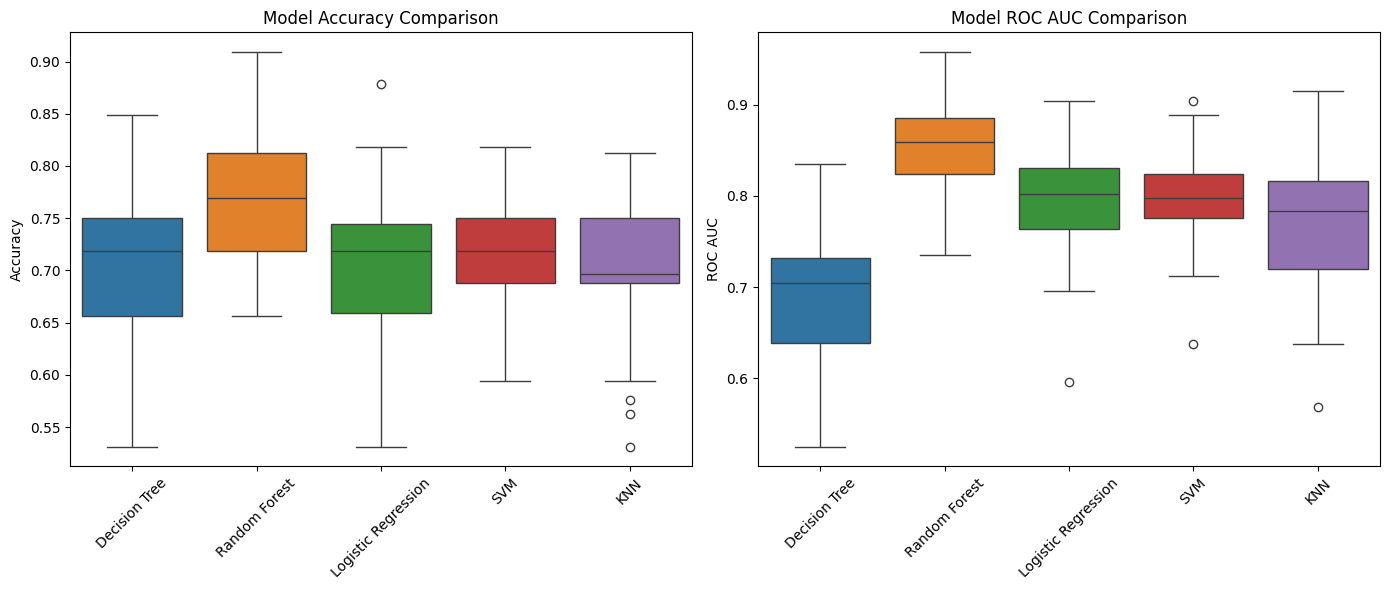

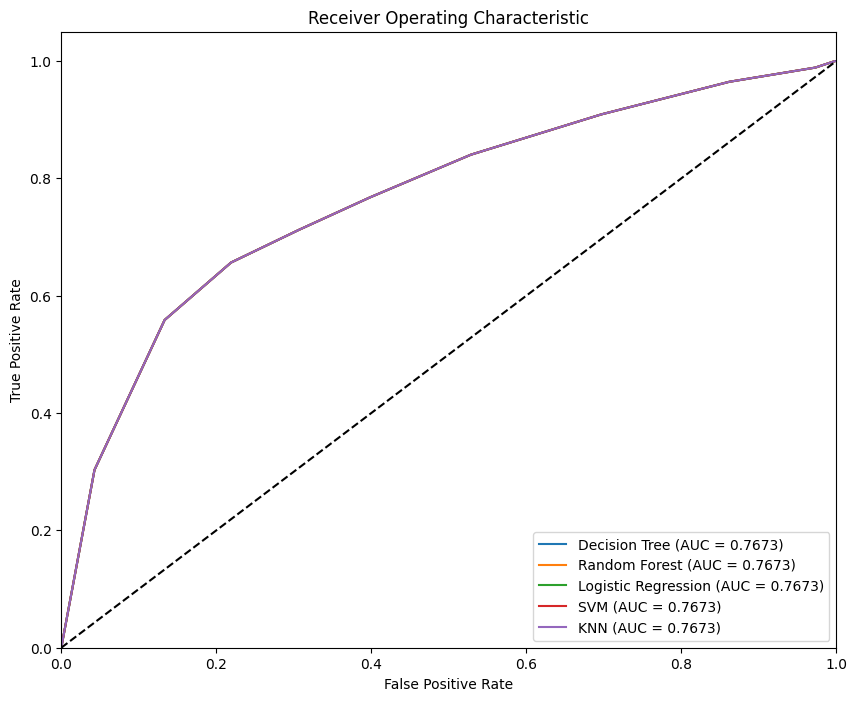

In [120]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

# Define the models (updated with probability support for ROC/AUC calculation)
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),  # Enable probability estimates for SVM
    'KNN': KNeighborsClassifier(n_neighbors=10)
}

# Define the number of folds and repetitions
n_splits = 5
n_repeats = 10
random_state = 0

# Initialize the RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

# To store the results
results = {model_name: {'accuracy': [], 'roc_auc': [], 'confusion_matrix': [], 'classification_report': []} for model_name in models}

# Evaluate each model using cross-validation
for model_name, model in models.items():
    accuracies = []
    roc_aucs = []
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        
        accuracies.append(accuracy_score(y_test, y_pred))
        roc_aucs.append(roc_auc_score(y_test, y_prob))
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)
    
    # Calculate and store results
    results[model_name]['accuracy'] = accuracies
    results[model_name]['roc_auc'] = roc_aucs
    results[model_name]['confusion_matrix'] = confusion_matrix(y_true_all, y_pred_all)
    results[model_name]['classification_report'] = classification_report(y_true_all, y_pred_all, output_dict=True)

Desenhar gráficos e tabelas com as estatísticas tiradas dos testes anteriores.


Model: Decision Tree
Mean Accuracy: 0.6966
Standard Deviation: 0.0744
Min Accuracy: 0.5000
Max Accuracy: 0.8485
Mean ROC AUC: 0.6796
Standard Deviation ROC AUC: 0.0770
Confusion Matrix:
[[381 249]
 [242 748]]
Classification Report:
              precision    recall  f1-score      support
0.0            0.611557  0.604762  0.608140   630.000000
1.0            0.750251  0.755556  0.752894   990.000000
accuracy       0.696914  0.696914  0.696914     0.696914
macro avg      0.680904  0.680159  0.680517  1620.000000
weighted avg   0.696314  0.696914  0.696601  1620.000000

Model: Random Forest
Mean Accuracy: 0.7715
Standard Deviation: 0.0536
Min Accuracy: 0.6562
Max Accuracy: 0.9394
Mean ROC AUC: 0.8557
Standard Deviation ROC AUC: 0.0493
Confusion Matrix:
[[434 196]
 [174 816]]
Classification Report:
              precision    recall  f1-score      support
0.0            0.713816  0.688889  0.701131   630.000000
1.0            0.806324  0.824242  0.815185   990.000000
accuracy       0.7716

/tmp/ipykernel_14342/3334179099.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models.keys(), rotation=45)
/tmp/ipykernel_14342/3334179099.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models.keys(), rotation=45)


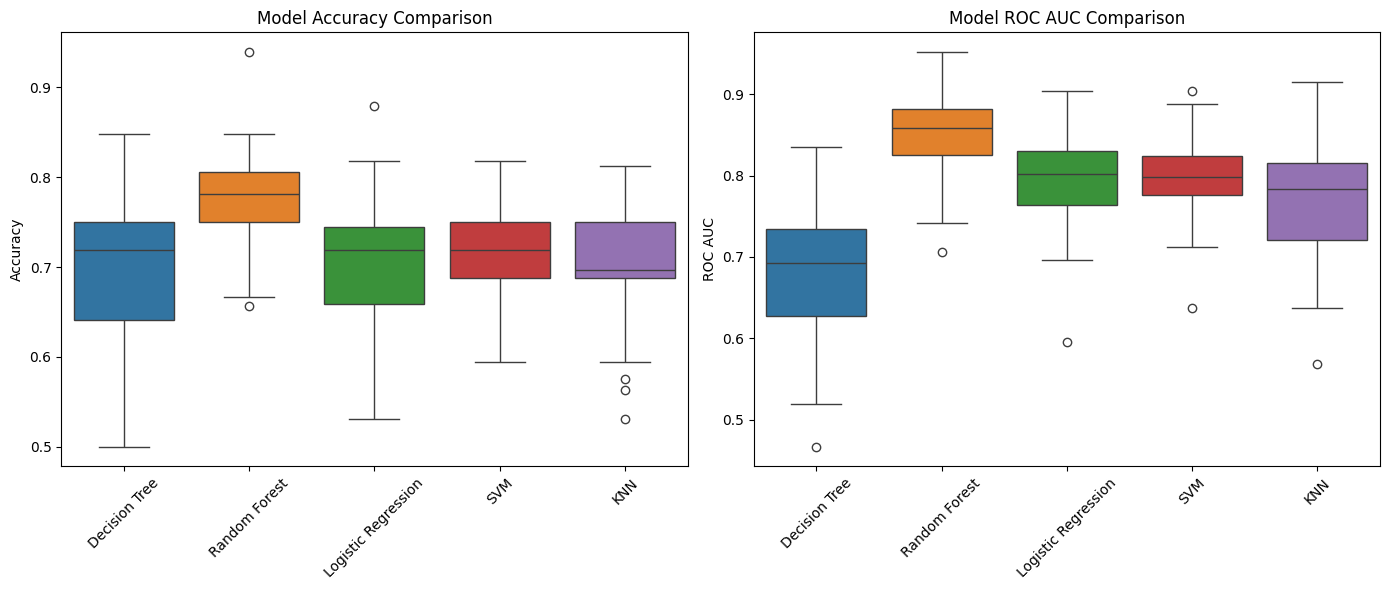

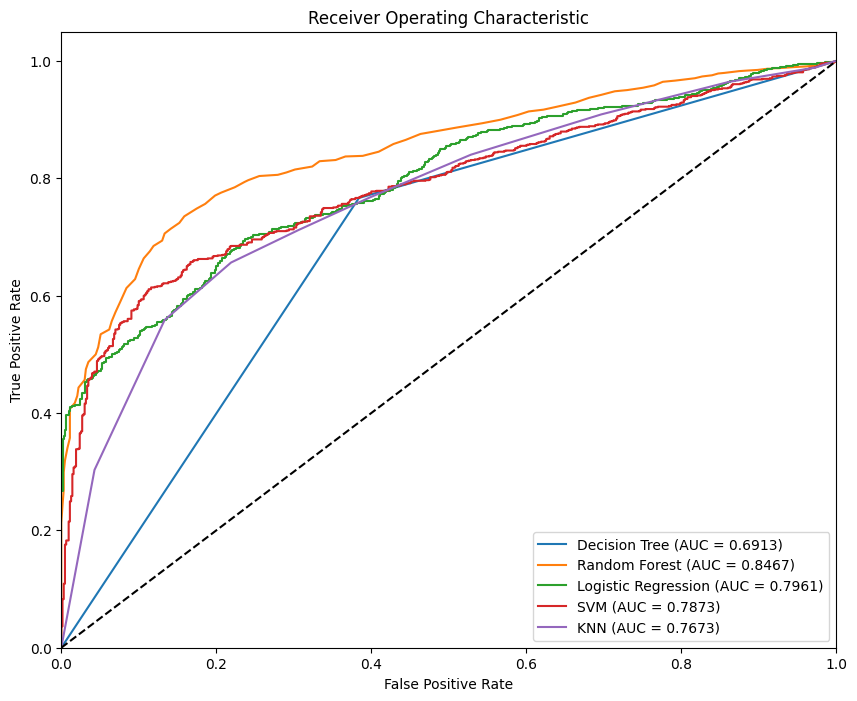

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Mean Accuracy: {np.mean(result['accuracy']):.4f}")
    print(f"Standard Deviation: {np.std(result['accuracy']):.4f}")
    print(f"Min Accuracy: {np.min(result['accuracy']):.4f}")
    print(f"Max Accuracy: {np.max(result['accuracy']):.4f}")
    print(f"Mean ROC AUC: {np.mean(result['roc_auc']):.4f}")
    print(f"Standard Deviation ROC AUC: {np.std(result['roc_auc']):.4f}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")
    print(f"Classification Report:\n{pd.DataFrame(result['classification_report']).transpose()}")

# Visualization using Matplotlib and Seaborn
# Boxplot for accuracy and ROC AUC
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=[results[model]['accuracy'] for model in models.keys()], ax=axes[0])
sns.boxplot(data=[results[model]['roc_auc'] for model in models.keys()], ax=axes[1])
axes[0].set_xticklabels(models.keys(), rotation=45)
axes[0].set_title('Model Accuracy Comparison')
axes[1].set_xticklabels(models.keys(), rotation=45)
axes[1].set_title('Model ROC AUC Comparison')
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('ROC AUC')
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_true_all = []
    y_prob_all = []
    for train_index, test_index in rskf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        
        y_true_all.extend(y_test)
        y_prob_all.extend(y_prob)

    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [121]:
X_test.columns

Index(['AFP', 'Hemoglobin', ' Albumin', 'AST', 'ALP', 'Dir_Bil', 'Iron',
       'Ferritin', 'Symptoms_Yes', 'PVT_Yes', 'Metastasis_Yes', 'PS_Active',
       'PS_Disabled', 'PS_Selfcare', 'Ascites_Moderate/Severe', 'Ascites_No'],
      dtype='object')

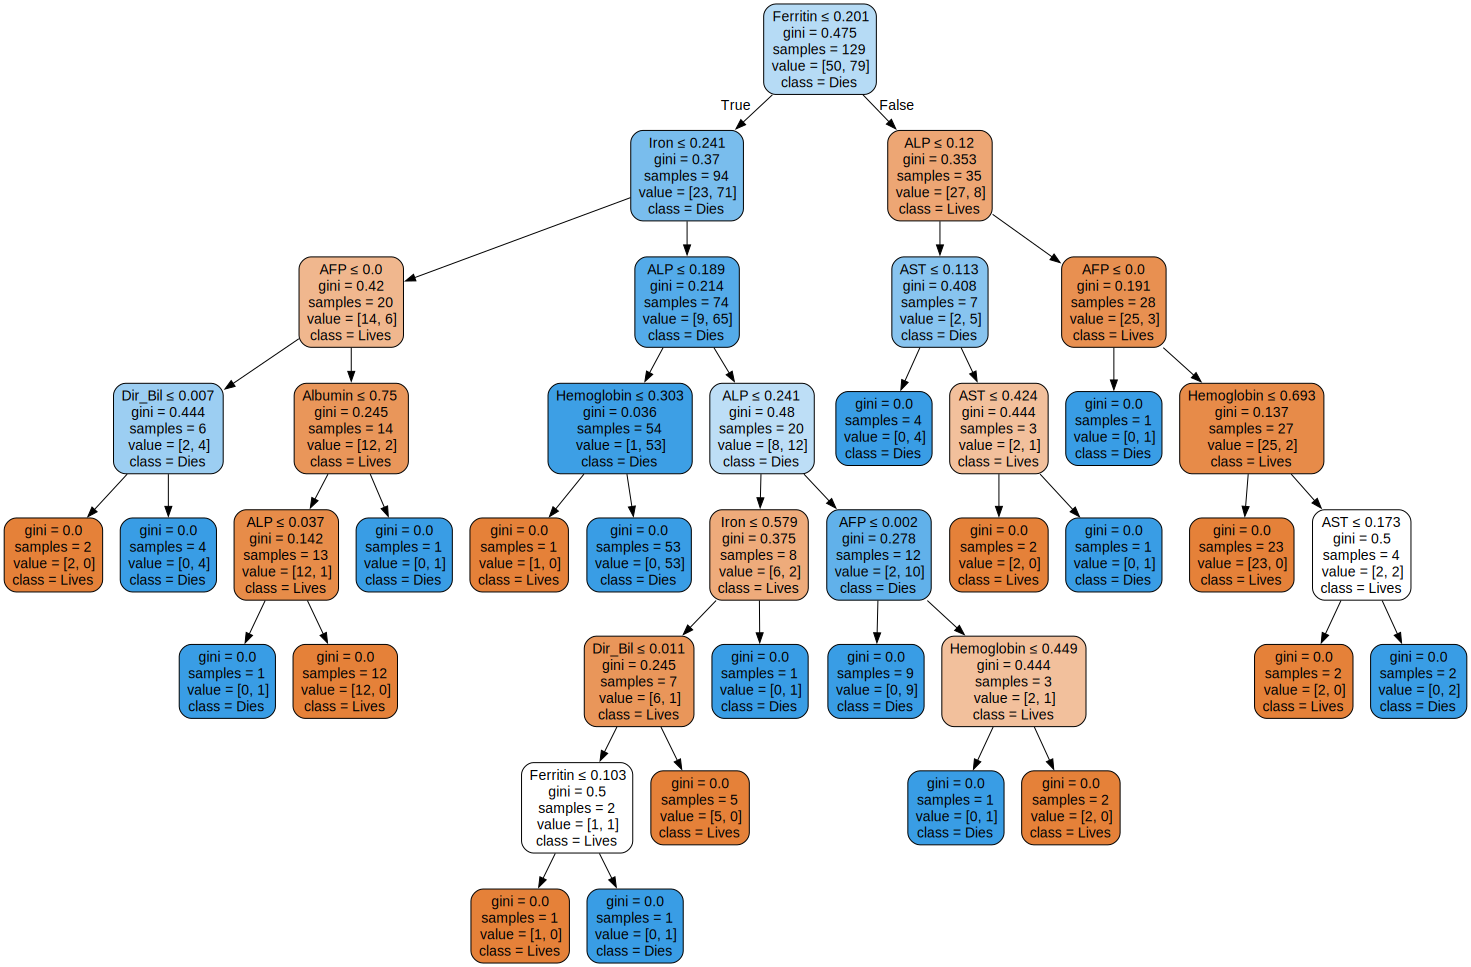

In [122]:
from sklearn import tree
import graphviz

# Assuming clf is your trained decision tree model
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=df.columns[:-1],  # Replace with your feature names
                                class_names=['Lives', 'Dies'],  # Replace with your class names
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("decision_tree_visualization", format="png", cleanup=True)

# Display the tree
graph
